In [1]:
# importing libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import nltk
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer,CountVectorizer

In [2]:
#connecting to database
con=sqlite3.connect("database.sqlite")

In [3]:
#querying 10000 reviews using pandas query
amazon_review_data=pd.read_sql_query("""select * from Reviews where score !=3 Limit 10000""",con)

In [4]:
amazon_review_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [5]:
# converting positve/negative based on score
def rating(x):
    if x < 3:
        return 0
    return 1

In [6]:
amazon_review_data["Score"]=amazon_review_data["Score"].map(rating)

In [7]:
amazon_review_data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [8]:
amazon_review_data.shape

(10000, 10)

In [9]:
#Querying duplicate reviews(user reviwed multiple products at same time)
duplicate_views= pd.read_sql_query("""SELECT  UserId,Time,count(ProductId) FROM Reviews GROUP BY Time,UserId HAVING COUNT(ProductId) >1""", con)

duplicate_views.head(2)


,UserId,Time,count(ProductId)
0,A344SMIA5JECGM,944438400,3
1,A1048CYU0OV4O8,947376000,3


In [10]:
#user gave same  reviews for different products at same time ,which is not possible
duplicate_display_user_view= pd.read_sql_query("""SELECT *  FROM Reviews where UserId='A344SMIA5JECGM'""", con)

duplicate_display_user_view

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
1,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
2,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


In [11]:
#sort data based on product Id
sorted_data=amazon_review_data.sort_values('ProductId',axis=0,ascending=True,inplace=False, kind='quicksort', na_position='last')

In [12]:
#remove duplicates based in userid,profilename,time and text
final_reviews=sorted_data.drop_duplicates({"UserId","ProfileName","Time","Text"},keep="first",inplace=False)

In [13]:
#checking how much percentage of values are dropped
(final_reviews.size)/(amazon_review_data.size)*100

95.64

In [14]:
final_reviews["Score"].value_counts()

1    7976
0    1588
Name: Score, dtype: int64

In [15]:
#extracting only reviwes where numerator is less than denominator
final_reviews=final_reviews[final_reviews.HelpfulnessNumerator<=final_reviews.HelpfulnessDenominator]

## Data Cleanup

In [16]:
# removing URL tags using regular expressions
import re
print("Orginal text Review : ",final_reviews.Text[305]+"\n")
print("formatted text : ", re.sub(r"http\S+","",final_reviews.Text[305]))


Orginal text Review :  Yes, I am having a cup right now.  I went all over town looking for this coffee after been invited to a non profit organization to a banquet and besides the delicious food they top it off with this amazing delicious coffee.  I paid and extra 20 bucks to get it right way and it is worth the money. Highly recommend.

formatted text :  Yes, I am having a cup right now.  I went all over town looking for this coffee after been invited to a non profit organization to a banquet and besides the delicious food they top it off with this amazing delicious coffee.  I paid and extra 20 bucks to get it right way and it is worth the money. Highly recommend.


In [17]:
#removing contractions using contractions library (eg :I'll-->i will ,I'd --I would)
import contractions
def decontracted(text):
    expanded_words=[]
    for word in text.split():
        expanded_words.append(contractions.fix(word))
    expanded_text=" ".join(expanded_words)
    return expanded_text

In [18]:
print("Orginal text: {}\n".format(final_reviews.Text[10]))
print("formatted text: {}".format(decontracted(final_reviews.Text[10])))

Orginal text: I don't know if it's the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind!  We picked up a bottle once on a trip we were on and brought it back home with us and were totally blown away!  When we realized that we simply couldn't find it anywhere in our city we were bummed.<br /><br />Now, because of the magic of the internet, we have a case of the sauce and are ecstatic because of it.<br /><br />If you love hot sauce..I mean really love hot sauce, but don't want a sauce that tastelessly burns your throat, grab a bottle of Tequila Picante Gourmet de Inclan.  Just realize that once you taste it, you will never want to use any other sauce.<br /><br />Thank you for the personal, incredible service!

formatted text: I do not know if it is the cactus or the tequila or just the unique combination of ingredients, but the flavour of this hot sauce makes it one of a kind! We picked up a bottle once on a tri

In [19]:
#removing tags like "<>" from text
from bs4 import BeautifulSoup
soup = BeautifulSoup(final_reviews.Text[1000], 'lxml')
print("Orginal text Review : {}\n".format(final_reviews.Text[1000]))
print("formatted text Review ",soup.text)


Orginal text Review : Gatorade G2 is the way to go when you want the benefits of Gatorade without quite so much sugar. As I am in a "pre-diabetes" state these days, I am drinking this type of Gatorade instead of the regular Gatorade which has noticeably more sugar in it. The really good thing is that this still replenishes carbs and electrolytes after I exercise without putting unnecessary extra sugar into my system.<br /><br />G2 comes in flavors including fruit punch and grape.<br /><br />If you're on the go, the advantage of these bottles of Gatorade is this: because the bottles are smaller you can carry them with you much easier than if you took the regular, larger size bottles of Gatorade G2.<br /><br />I highly recommend this drink if you need extra carbs or electrolytes after exercising; it replenishes them very well without the extra sugar found in regular Gatorade.

formatted text Review  Gatorade G2 is the way to go when you want the benefits of Gatorade without quite so much

In [20]:
#importing natural language processing tool kit
#import stop words
import nltk
from nltk.corpus import stopwords 
nltk.download('punkt')
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stopwords = stopwords.words('english')

#import stemmer
from nltk.stem import SnowballStemmer
snowball_stemmer = SnowballStemmer('english')

#import Lemittizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
word_lemmet = WordNetLemmatizer()

def words_tune(text):
    word_tokens=word_tokenize(text)
    #removing_stop_words=' '.join(word.lower() for word in text.split() if word.lower() not in stopwords)
    removing_stop_words=' '.join(word.lower() for word in text.split() if word.lower() not in stopwords)
    #stem_words=[snowball_stemmer.stem(word) for word in word_tokens]
    #lemet_words=[word_lemmet.lemmatize(word) for word in word_tokens]
    return removing_stop_words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\srini\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srini\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\srini\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
print("Orginal text Review : {}\n".format(final_reviews.Text[100]))
print("formatted text Review with stop words : {} \n".format(words_tune(final_reviews.Text[100])))
#print("formatted text Review with stematizer : {} \n".format(words_tune(final_reviews.Text[100])[1]))
#print("formatted text Review with Lemmatizer : {} \n".format(words_tune(final_reviews.Text[100])[2]))

Orginal text Review : I was diappointed in the flavor and texture of this mix.  I usually like most of the Low Carb things I have tried, but was diappointed in this specific one.

formatted text Review with stop words : diappointed flavor texture mix. usually like low carb things tried, diappointed specific one. 



In [22]:
#performing cleanup and creating final reviw using above methods by removing stop words
from tqdm import tqdm
processed_reviews_with_stop_words=[]
for sentence in tqdm(final_reviews['Text'].values):
    #removing urls from text
    sentence= re.sub(r"http\S+","",sentence)
    #removing tags in the text
    sentence=BeautifulSoup(sentence, 'lxml').text
    #removing contractions using contractions library (eg :I'll-->i will ,I'd --I would)
    sentence=decontracted(sentence)
    #removing digits from text
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    #removing punctuational characters from text
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    #applying stop words
    sentence=words_tune(sentence)
    processed_reviews_with_stop_words.append(sentence)
    
    


100%|█████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:21<00:00, 449.12it/s]


In [23]:
#performing cleanup and creating final reviw using above methods by removing stop words
processed_reviews_without_stop_words=[]
for sentence in tqdm(final_reviews['Text'].values):
    #removing urls from text
    sentence= re.sub(r"http\S+","",sentence)
    #removing tags in the text
    sentence=BeautifulSoup(sentence, 'lxml').text
    #removing contractions using contractions library (eg :I'll-->i will ,I'd --I would)
    sentence=decontracted(sentence)
    #removing digits from text
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    #removing punctuational characters from text
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    #applying stop words
    #sentence=words_tune(sentence)
    processed_reviews_without_stop_words.append(sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:12<00:00, 790.45it/s]


## Apply Data Preprocessign techniques on Reviews

In [24]:
#applying bag of words using Countvectorizer
count_vector=CountVectorizer()
Bag_ofWords_vector=count_vector.fit_transform(processed_reviews_with_stop_words)
print("{} rows  and {} dimensions".format(Bag_ofWords_vector.get_shape()[0],Bag_ofWords_vector.get_shape()[1]))


9564 rows  and 18148 dimensions


In [25]:
#applying Bi grams and n-grams
gram_count_vector=CountVectorizer(ngram_range=(1,2),min_df=10)
bigram_count=gram_count_vector.fit_transform(processed_reviews_without_stop_words)
print("{} rows  and {} dimensions".format(bigram_count.get_shape()[0],bigram_count.get_shape()[1]))

9564 rows  and 12096 dimensions


In [26]:
#applying tf-idf
f_idf_vect=TfidfVectorizer(ngram_range=(1,2),min_df=10)
tf_idf_count=tf_idf_vect.fit_transform(processed_reviews_without_stop_words)
print("{} rows  and {} dimensions".format(tf_idf_count.get_shape()[0],tf_idf_count.get_shape()[1]))

9564 rows  and 12096 dimensions


In [27]:
#implementing word2vec
import os
from gensim.models import Word2Vec,KeyedVectors

i=0
list_of_sentance=[]
for sentance in processed_reviews_without_stop_words:
    list_of_sentance.append(sentance.split())

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    w2v_model=Word2Vec(list_of_sentance,min_count=5,vector_size=50, workers=4)
    print("Completed")


In [28]:
#finding similar words based on built in existing reviwes
print(w2v_model.wv.most_similar('great'))

[('wonderful', 0.8777118921279907), ('good', 0.8035871982574463), ('fantastic', 0.7924948334693909), ('perfect', 0.7623525857925415), ('amazing', 0.7455849051475525), ('awesome', 0.7384247183799744), ('delicious', 0.7132108807563782), ('excellent', 0.7045275568962097), ('decent', 0.6870899200439453), ('nice', 0.6806646585464478)]


In [29]:
print(w2v_model.wv.most_similar('worst'))

[('best', 0.836672842502594), ('smoothest', 0.785223126411438), ('decaf', 0.7626327872276306), ('tastiest', 0.757561981678009), ('Switch', 0.7455514669418335), ('greatest', 0.7426635026931763), ('Canin', 0.7329196929931641), ('particular', 0.7314881682395935), ('strongest', 0.7312579154968262), ('name', 0.7284085750579834)]


In [30]:
w2v_words = list(w2v_model.wv.key_to_index)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6723
sample words  ['I', 'the', 'and', 'a', 'to', 'is', 'it', 'of', 'not', 'for', 'this', 'in', 'have', 'that', 'are', 'with', 'you', 'my', 'was', 'but', 'on', 'as', 'like', 'they', 'The', 'them', 'so', 'good', 'can', 'these', 'be', 'will', 'or', 'taste', 'at', 'do', 'coffee', 'just', 'This', 'would', 'great', 'very', 'product', 'one', 'am', 'all', 'flavor', 'It', 'from', 'has']


In [31]:
#implementing TF-IDF W2VEC
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(processed_reviews_with_stop_words)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

tfidf_feat = model.get_feature_names() 
tfidf_sent_vectors = [];
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 9564/9564 [04:26<00:00, 35.94it/s]


In [32]:
# splitting reviwes as independing variable and score as dependent varaiable

X=processed_reviews_with_stop_words
Y=final_reviews.Score

from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=32)



In [33]:
#creating a function for roc and confusion matriz
def model_roc_confusion_matrix(model,X_train_data,X_test_data,Y_train_data,Y_test_data):
    pred_proba_train=model.predict_proba(X_train_data)[:,1]
    fpr_train,tpr_train,thresholds_train = roc_curve(Y_train_data,pred_proba_train)
    
    pred_proba_test=model.predict_proba(X_test_data)[:,1]
    fpr_test,tpr_test,thresholds_test = roc_curve(Y_test_data,pred_proba_test)
    
    
    plt.figure(figsize=(18,5))
    plt.subplot(1,3,1)
    plt.plot(fpr_train,tpr_train,label="Train ROC ,AUC="+str(roc_auc_score(Y_train_data,pred_proba_train)))
    plt.plot(fpr_test,tpr_test,label="Test ROC ,AUC="+str(roc_auc_score(Y_test_data,pred_proba_test)))
    

    plt.title("ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()
    
    
    
    #model.fit(X_train_data,Y_train_data)
    Y_pred_train=model.predict(X_train_data)
    confusion_matrix_train=confusion_matrix(Y_train_data,Y_pred_train)
    class_label = ["negative", "positive"]
    plt.figure(figsize=(18,5))
    plt.subplot(1,3,2)
    df_train = pd.DataFrame(confusion_matrix_train, index = class_label, columns = class_label)
    sns.heatmap(df_train,annot=True,fmt="d")
    plt.title("Confusion Matrix for Training data")
    plt.xlabel("predicted label")
    plt.ylabel("True label")
    plt.show()
    
   
    Y_pred_test=model.predict(X_test_data)
    confusion_matrix_test=confusion_matrix(Y_test_data,Y_pred_test)
    class_label = ["negative", "positive"]
    plt.figure(figsize=(18,5))
    plt.subplot(1,3,3)
    df_test = pd.DataFrame(confusion_matrix_test, index = class_label, columns = class_label)
    sns.heatmap(df_test,annot=True,fmt="d")
    plt.title("Confusion Matrix for Test data")
    plt.xlabel("predicted label")
    plt.ylabel("True label")
    plt.show()



In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix


count_vect = CountVectorizer()
X_train_bow=count_vect.fit_transform(X_train)
X_test_bow=count_vect.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train_bow = scalar.fit_transform(X_train_bow)
X_test_bow= scalar.transform(X_test_bow)



base_learners = [20,40,60,80,100,120]
depths=[1,5,10,50,100,500,1000]

param_grid={'n_estimators': base_learners, 'max_depth':depths}
rf = RandomForestClassifier(max_features='sqrt')
gv_rfc_model=GridSearchCV(rf,param_grid,scoring='roc_auc',n_jobs=-1,cv=3)
gv_rfc_model.fit(X_train_bow,Y_train)

print("optimal n_estimators",gv_rfc_model.best_estimator_.n_estimators)
print("optimal max_depth",gv_rfc_model.best_estimator_.max_depth)

optimal n_estimators 120
optimal max_depth 50


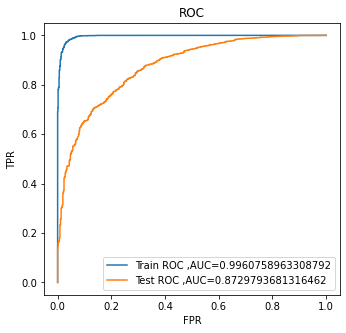

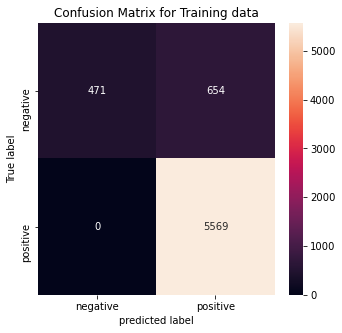

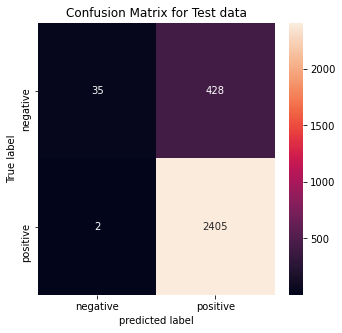

In [35]:
model_roc_confusion_matrix(gv_rfc_model,X_train_bow,X_test_bow,Y_train,Y_test)

In [36]:
from xgboost import XGBClassifier

base_learners = [20,40,60,80,100,120]
depths=[1,5,10,50,100,500,1000]
param_grid={'n_estimators': base_learners, 'max_depth':depths}
xgbc=XGBClassifier(booster='gbtree')
model_xgbc_gcv=GridSearchCV(xgbc,param_grid,scoring='roc_auc',n_jobs=-1,cv=3)
model_xgbc_gcv.fit(X_train_bow,Y_train)

print("optimal n_estimators",model_xgbc_gcv.best_estimator_.n_estimators)
print("optimal max_depth",model_xgbc_gcv.best_estimator_.max_depth)

[13:52:57] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
optimal n_estimators 120
optimal max_depth 5


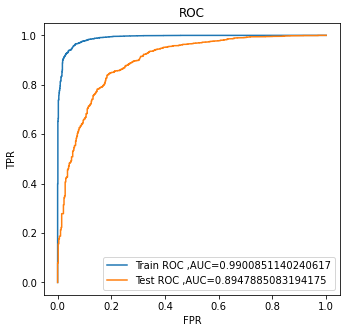

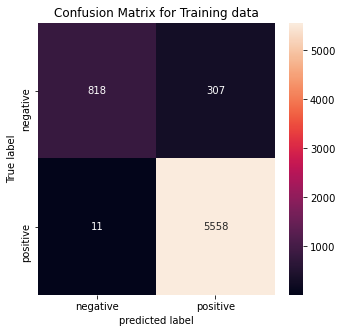

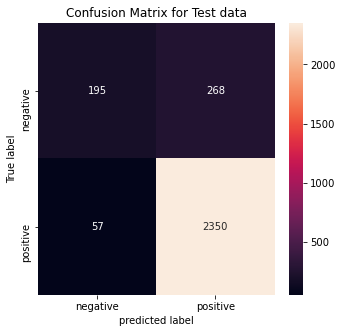

In [37]:
model_roc_confusion_matrix(model_xgbc_gcv,X_train_bow,X_test_bow,Y_train,Y_test)

In [74]:
# Applying XGBOOST on TFIDF W2V
# Please write all the code with proper documentation
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,vector_size=50, workers=4) 
w2v_words = list(w2v_model.wv.key_to_index)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(X_train)


tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1


#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1    

100%|█████████████████████████████████████████████████████████████████████████████| 2870/2870 [00:03<00:00, 811.46it/s]


In [78]:
X_train_tfw2v=np.array(tfidf_sent_vectors_train)
X_test_tfw2v=np.array(tfidf_sent_vectors_test)

In [81]:
base_learners = [20,40,60,80,100,120]
depths=[1,5,10,50,100,500,1000]
param_grid={'n_estimators': base_learners, 'max_depth':depths}
xgbc=XGBClassifier(booster='gbtree')
model_xgbc_gcv=GridSearchCV(xgbc,param_grid,scoring='roc_auc',n_jobs=-1,cv=3)
model_xgbc_gcv.fit(X_train_tfw2v,Y_train)




[14:39:48] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=N

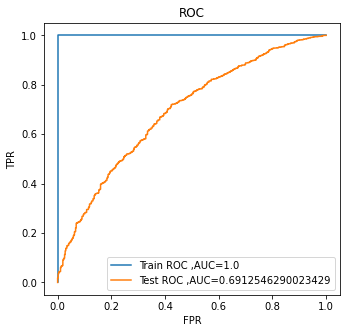

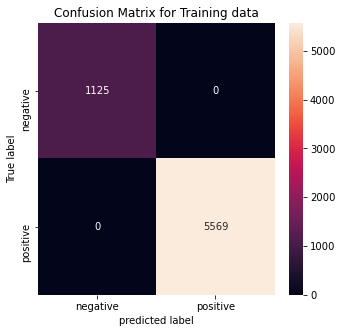

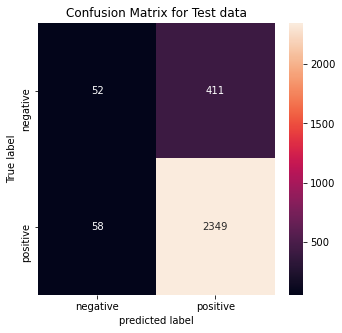

In [82]:
model_roc_confusion_matrix(model_xgbc_gcv,X_train_tfw2v,X_test_tfw2v,Y_train,Y_test)